# Neural Networks

In [1]:
# load libs
import sys
sys.path.append("../")

import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import math
from neural_network import *
from image_recognition import *

Neural network consists of L total layers: 1 input layer ($x^{(0)}$), $L - 2$ hidden layers ($a^{(1)} ... a^{(l - 1)}$) and 1 output layer ($a^{(L)}$):

$$
\begin{bmatrix}
x^{(0)}_{0}\\
x^{(0)}_{1}\\
x^{(0)}_{2}
\end{bmatrix}
\begin{bmatrix}
a^{(1)}_{0}\\
a^{(1)}_{1}\\
a^{(1)}_{2}\\
a^{(1)}_{3}\\
a^{(1)}_{4}\\
\end{bmatrix}
...
\begin{bmatrix}
a^{(l - 1)}_{0}\\
a^{(l - 1)}_{1}\\
a^{(l - 1)}_{2}\\
a^{(l - 1)}_{3}\\
a^{(l - 1)}_{4}\\
\end{bmatrix}
\begin{bmatrix}
a^{(L)}_{0}\\
a^{(L)}_{1}\\
a^{(L)}_{2}\\
\end{bmatrix}
$$

Each layer's unit is a logistic regression classifier and connected to the next layer's units with edges of weight $\theta^{(l)}_{ij}$.

## Forward Propagation

Propagating values from left to right to calculate output layer's values.

Input layer:

$$a^{(0)} = X$$

Hidden and output layers:

$$a^{(l + 1)} = g((\Theta^{(l)})^T a^{(l)})$$

where $g$ is a logistic regression sigmoid function.

In [2]:
# %load -s forward_propagation ../neural_network.py
def forward_propagation(layer_coefficients, input_data):
    """
    Calculate neural network output based on input data and layer coefficients.
    Forward propagation algorithm.

    :param layer_coefficients: 1 x (L - 1) array of layer coefficients vectors, where L - layers count
    :param input_data: S0 x m input layer vector, where S0 - input layer units count, m - experiments count
    :return: 1 x l vector of layer activation vectors Sl x m, where Sl - l'th layer units count,
             m - experiments count
    """
    data = [input_data]  # S0 x m

    for theta in layer_coefficients:
        data.append(
            sigmoid(np.dot(
                theta,  # Sl x (S[l-1] + 1)
                np.vstack(([np.ones(data[-1].shape[1])], data[-1]))  # (S[l-1] + 1) x m
            ))  # Sl x m
        )

    return data


In [3]:
# load neural network data and weights
data = scipy.io.loadmat('../data/ex3data1.mat')
x = data['X']  # m x n^2, where m - experiments count, n - square image size
y = data['y']  # m x 1 vector of image classes (numbers 0 - 9)

weights = scipy.io.loadmat('../data/ex3weights.mat')
nn_coefficients = (
    weights['Theta1'],  # S1 x (n^2 + 1), where S1 - hidden layer size, n - square image size
    weights['Theta2']   # SL x (S1 + 1), where SL - output layer size, S1 - hidden layer size
)

In [4]:
# find index of the output unit with the max value
def predict_digit(nn_coefficients, image):
    output_data = forward_propagation(nn_coefficients, image)[-1]
    max_index = np.argmax(output_data) + 1
    
    # data set contains 10 instead of 0
    return max_index if max_index < 10 else 0

Predicting digits using already pre-trained neural network $\Theta$ weights.

In [5]:
# predict images
nn_predictions = [predict_digit(nn_coefficients, image.reshape(image.size, 1)) for image in x]
print_predictions_accuracy(nn_predictions, y)

Prediction accuracy = 97.52%


[2, 6, 5, 2, 9, 5, 7, 2, 4, 0, 8, 3, 5, 8, 1, 9, 2, 4, 6, 4]


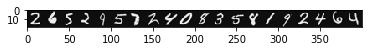

In [6]:
predict_random_images(nn_predictions, x)

## Cost Function

Given that $L$ - number of layers, $s_l$ - number of units in layer $l$:

$$J(\Theta) = - \frac{1}{m} \sum_{i=0}^{m} \sum_{k=0}^{S_L} 
        [{ y^{(i)}_k log(h(X^{(i)})_k) + (1 - y^{(i)}_k) log(1 - h(X^{(i)})_k) }] 
    + \frac{\lambda}{2 m} \sum_{l=0}^{L} \sum_{i=0}^{s_l} \sum_{j=1}^{s_i} (\theta^{(l)}_{ij})^2$$
    
Calculating cost function as a sum of the last layer's cost functions regularized over all $\Theta^{(l)}_{ij}$ coefficient values.

In [7]:
# %load -s roll_vector_to_list_of_matrices ../neural_network.py
def roll_vector_to_list_of_matrices(v, shapes):
    first = 0
    result = []

    for shape in shapes:
        last = first + shape[0] * shape[1]
        result.append(np.array(v[first:last]).reshape(shape[0], shape[1]))
        first = last

    return result


In [8]:
# %load -s unroll_list_of_matrices_to_vector ../neural_network.py
def unroll_list_of_matrices_to_vector(l):
    result_vector = np.array([])
    original_shape = []

    for m in l:
        original_shape.append(m.shape)
        result_vector = np.hstack([
            result_vector,
            m.reshape(m.shape[0] * m.shape[1])
        ])

    return original_shape, result_vector


In [9]:
# %load -s nn_cost_function ../neural_network.py
def nn_cost_function(layer_coefficients, x, y):
    """
    Calculate cost function for neural network

    :param layer_coefficients: 1 x (L - 1) array of layer coefficients vectors, where L - layers count
    :param x: S0 x m input layer vector, where S0 - input layer units count, m - experiments count
    :param y: SL x m expected results matrix, where Sl - output layer units count, m - experiments count
    :return: summary cost
    """
    return - 1 / y.shape[1] * np.sum((
            np.multiply(y, np.log(forward_propagation(layer_coefficients, x)[-1]))  # SL x m
            +
            np.multiply((1 - y), np.log(1 - forward_propagation(layer_coefficients, x)[-1]))  # SL x m
    ))


In [10]:
# check cost function value for provided neural network coefficients
def digit_to_output_vector(digit):
    """
    Returns 10 x 1 vector with all 0 except 1 for index corresponding to the provided digit.
    If digit == 0, then 10th element == 1.
    """
    out = np.zeros(10)
    out[9 if digit == 0 else digit - 1] = 1
    return out


expected_output = np.array([digit_to_output_vector(d) for d in y]).transpose()
nn_cost_function(nn_coefficients, x.transpose(), expected_output)

0.287629165161319

In [11]:
# %load -s nn_regularized_cost_function ../neural_network.py
def nn_regularized_cost_function(unrolled_layer_coefficients, shape, x, y, regularization_rate):
    """
    Regularized neural network cost function.
    See nn_cost_function description.
    """
    layer_coefficients = roll_vector_to_list_of_matrices(unrolled_layer_coefficients, shape)

    cost = nn_cost_function(layer_coefficients, x, y)

    for theta in layer_coefficients:
        unrolled_theta = theta.reshape(theta.shape[0] * theta.shape[1], 1)

        cost += regularization_rate / (2 * y.shape[1]) \
                * (unrolled_theta.transpose() @ unrolled_theta)[0, 0]

    return cost


In [12]:
# check regularized cost function value for provided neural network coefficients
original_shape, unrolled_nn_coefficients = unroll_list_of_matrices_to_vector(nn_coefficients)

nn_regularized_cost_function(unrolled_nn_coefficients, original_shape, x.transpose(), expected_output, 1)

0.38448779624289403

## Backpropagation Algorithm

Is used to calculate cost function first derivative over all l, i, j:
$$\frac{dJ}{d\Theta^{(l)}_{ij}}$$

Lets introduce cost function error $\delta^{(l)}$ for each layer $l$ and propagate this value from right to left.

For the last layer $L$: 
$$\delta^{(L)} = a^{(L)} - y$$

For $[2, L-1]$ layers:
$$\delta^{(l)} = (\Theta^{(l)})^T \delta^{(l + 1)} \cdot g^{'}(z^{(l)})$$

In [13]:
# %load -s back_propagation ../neural_network.py
def back_propagation(layer_coefficients, y, output):
    """
    Calculate error delta values for each layer and unit

    :param layer_coefficients: 1 x (L - 1) array of layer coefficients vectors, where L - layers count
    :param y: SL x m expected results matrix, where SL - output layer units count, m - experiments count
    :param output: 1 x l vector of layer activation vectors Sl x m, where Sl - l'th layer units count,
             m - experiments count
    :return: 1 x (L - 1) vector of Sl x m delta values
    """
    delta = [output[-1] - y]

    for l in reversed(range(1, len(layer_coefficients))):
        delta.insert(
            0,
            np.multiply(
                np.dot(
                    layer_coefficients[l].transpose(),  # (Sl + 1) x S[l + 1]
                    delta[0]  # S[l + 1] x m
                )[1:, :],  # Sl x m
                sigmoid_derivative(output[l])  # Sl x m
            )
        )

    return delta


Recall that: 
$$a^{(l)} = g(z^{(l)}) = \frac{1}{1 + e^{-z^{(l)}}}$$

$$z^{(l)} = (\Theta^{(l - 1)})^T a^{(l - 1)}$$

And sigmoid function's first derivative: 
$$g^{'}(z^{(l)}) = g(z^{(l)}) \cdot (1 - g(z^{(l)})) = a^{(l)} \cdot (1 - a^{(l)})$$

Shows sensitivity of the sigmoid function to the change in input $z$.

In [14]:
# %load -s sigmoid_derivative ../neural_network.py
def sigmoid_derivative(z):
    """
    Calculate sigmoid function derivative dg/dz
    """
    return np.multiply(z, 1 - z)


Then:
$$\delta^{(l)} = (\Theta^{(l)})^T \delta^{(l + 1)} \cdot a^{(l)} \cdot (1 - a^{(l)})$$

Each $\delta^{(l)}$ contributes to the total layer's delta:
$$\Delta^{(l)} := \Delta^{(l)} + \delta^{(l + 1)} (a^{(l)})^T$$

Then $J(\Theta)$ first derivative can be calculated as:
$$\frac{dJ}{d\Theta^{(l)}_{ij}} = \frac{1}{m} \Delta^{(l)}_{ij}, j = 0$$

$$\frac{dJ}{d\Theta^{(l)}_{ij}} = \frac{1}{m} \Delta^{(l)}_{ij} 
    + \frac{\lambda}{m}\Theta^{(l)}_{ij}, j \gt 0$$

In [15]:
# %load -s nn_gradient ../neural_network.py
def nn_gradient(layer_coefficients, x, y):
    """
    Neural network gradient (derivative) function

    :param layer_coefficients: 1 x (L - 1) array of layer coefficients vectors, where L - layers count
    :param x: S0 x m input layer vector, where S0 - input layer units count, m - experiments count
    :param y: SL x m expected results matrix, where SL - output layer units count, m - experiments count
    :return: 1 x (L - 1) vector of S[l + 1] x (Sl + 1) gradient values
    """
    output = forward_propagation(layer_coefficients, x)  # l, Sl x m
    deltas = back_propagation(layer_coefficients, y, output)  # l, Sl x m

    grad = []

    for l in range(len(deltas)):
        grad.append(
            1 / y.shape[1] * np.dot(
                deltas[l],  # S[l + 1] x m
                np.vstack([np.ones(output[l].shape[1]), output[l]]).transpose()  # m x (Sl + 1)
            )  # S[l + 1] x (Sl + 1)
        )

    return grad


In [16]:
# %load -s nn_regularized_gradient ../neural_network.py
def nn_regularized_gradient(unrolled_layer_coefficients, shape, x, y, regularization_rate):
    """
    Regularized neural network gradient.
    See nn_gradient description.
    """
    layer_coefficients = roll_vector_to_list_of_matrices(unrolled_layer_coefficients, shape)

    gradients = nn_gradient(layer_coefficients, x, y)

    reg_gradients = []

    for l in range(len(layer_coefficients) - 1):
        reg_gradients.append(
            gradients[l]  # S[l + 1] x (Sl + 1)
            + regularization_rate / y.shape[1]
            * np.hstack([
                np.zeros((layer_coefficients[l].shape[0], 1)),
                layer_coefficients[l][:, 1:]
            ])  # S[l + 1] x (Sl + 1)
        )

    reg_gradients.append(gradients[-1])

    return unroll_list_of_matrices_to_vector(reg_gradients)[1]


Train neural network, find coefficients:

In [21]:
original_shape = ((25, 401), (10, 26))
initial_coefficients = np.random.uniform(-0.12, 0.12, 25*401 + 10*26)

coefficients_vector = optimize.fmin_cg(nn_regularized_cost_function,
                                       initial_coefficients,
                                       fprime=nn_regularized_gradient,
                                       args=(original_shape, x.transpose(), expected_output, 1),
                                       maxiter=50)

nn_learned_coefficients = roll_vector_to_list_of_matrices(coefficients_vector, original_shape)

         Current function value: 0.395482
         Iterations: 78
         Function evaluations: 243
         Gradient evaluations: 231


In [22]:
nn_new_predictions = [predict_digit(nn_learned_coefficients, image.reshape(image.size, 1)) for image in x]
print_predictions_accuracy(nn_new_predictions, y)

Prediction accuracy = 98.26%


[2, 9, 1, 3, 0, 3, 0, 6, 3, 6, 4, 2, 4, 6, 4, 2, 1, 9, 5, 6]


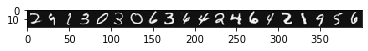

In [23]:
predict_random_images(nn_new_predictions, x)